<center>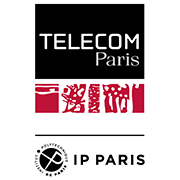</center>

------------------------

<br />

<h1><center><strong><font color="chillipepper"> BGDIA : Machine Learning Avancé </font></strong></center></h1>
<h3><center><font color="black"><strong> Mastère Spécialisé : Big Data, Gestion et Analyse de données massives </strong></font></center></h3>
<h2><center><font color="red"><strong> Projet : Training a VAE on MNIST </strong></font></center></h2>

<center>
<h3> Etudiant : MAHAMAT ATTEÏB Adoum </h3>
<br/>
</center>

<br />

------------------------


























Avant d'entrer dans le vif du sujet, il serait intéressant de définir ce qu'un auto-encodeur variationnel (VAE). Le VAE convertit les données d'entrée en un vecteur de représentation variationnelle (comme son nom l'indique), où les éléments de ce vecteur représentent différents attributs concernant la distribution des données d'entrée. 

Cette propriété probabiliste de la VAE en fait un modèle génératif. La représentation latente dans VAE est composée d'une distribution de probabilité ( μ, σ) qui définit le mieux nos données d'entrée.

<div style="text-align: center;">
    <img src="image_encodeur.png" alt="alternative text" style="margin: 0 auto;"/>
</div>

Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

    Navigate to Edit→Notebook Settings
    select GPU from the Hardware Accelerator drop-down
    
You can check if the GPU works with nvidia-smi.


## Importation de librairies
Let's import some libraries and load the MNIST dataset.

In [38]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
import torchvision

### Vérifier l'existence du GPU

On vérifie la disponibilité du "GPU", en cas d'indisponibilité, on utilise le "CPU".

In [39]:
print(torch.cuda.is_available())  # Doit être True si CUDA est disponible
print(torch.version.cuda)  # Affiche la version CUDA pour laquelle PyTorch a été compilé

False
None


In [40]:
device = torch.device("cpu")  # Définir l'appareil pour utiliser le CPU

## Chargement du jeu de données MNIST

Le jeu de données MNIST (Modified National Institute of Standards and Technology database) est l'un des ensembles de données les plus populaires utilisés dans le domaine de l'apprentissage automatique et du deep learning, en particulier pour les tâches de reconnaissance d'images. Il s'agit d'une large base de données de chiffres manuscrits qui est couramment utilisée pour entraîner divers systèmes de traitement d'images.

Chaque image est de taille 28x28 pixels, où chaque pixel représente l'intensité de la lumière à cet emplacement, avec des valeurs allant de 0 (noir) à 255 (blanc).

In [41]:
bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

## Affichage des images manuscrits de train

Il serait intéressant d'afficher les données manuscrites.

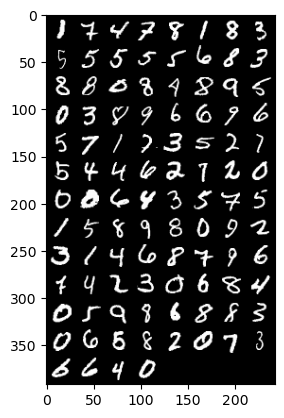

In [56]:
# Fonction pour afficher une grille d'images
def imshow(img):
    img = img.numpy()  # Convertir le tensor en un numpy array
    plt.imshow(np.transpose(img, (1, 2, 0)))  # Transposer les dimensions
    plt.show()

# Récupérer un lot d'images et de labels
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Afficher les images
imshow(torchvision.utils.make_grid(images))

# Afficher les labels correspondants
# print(' '.join('%5s' % labels[j].item() for j in range(len(labels))))

In [43]:
# installation de torchvision
# conda install pytorch torchvision cpuonly -c pytorch

## Architecture specification

You can use the following encoder (don't forget that in a VAE the decoder has two heads, for the mean and the variance):
```
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
```
and this decoder:
```
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
```
Then, you need to complete the forward function. You can use Relu activations for every layers except for the heads that can reach negative values. Concerning the decoder head, you can use sigmoid to obtain values in [0,1].

Here we consider a latent space of dimension 2 but is could be any *zdim* dimension.

On présente les différentes étapes de la classe VAE :

**Encoder :** Le réseau encoder prend une image d'entrée (aplatie si nécessaire, comme pour les images MNIST de 28x28 pixels) et la traite à travers deux couches linéaires avec activations ReLU. Ensuite, deux têtes séparées prédisent respectivement mu (la moyenne) et log_var (le logarithme de la variance) de la distribution latente.

**Sampling :** La méthode sampling génère un échantillon à partir de la distribution latente en utilisant l'astuce de ré-échantillonnage pour permettre la rétropropagation.

**Decoder :** Le réseau decoder prend un échantillon de l'espace latent et le reconstruit en une image à travers trois couches linéaires, avec les deux premières utilisant des activations ReLU et la dernière utilisant une activation sigmoid pour contraindre les sorties entre 0 et 1, correspondant à des intensités de pixel normalisées.

**Forward :** La méthode forward fait appel à l'encoder pour obtenir mu et log_var, utilise sampling pour obtenir un échantillon z de l'espace latent, puis passe cet échantillon au decoder pour reconstruire l'image. Elle retourne l'image reconstruite ainsi que les paramètres mu et log_var pour le calcul de la perte VAE durant l'entraînement.

In [44]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim) # For mu
        self.fc32 = nn.Linear(h_dim2, z_dim) # For log_variance

        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.fc31(h)
        log_var = self.fc32(h)
        return mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std) # std is used only for its dimensions
        return mu + eps*std
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h))

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784)) # Make sure input tensor is flattened
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

**Dans l'encodeur, les vecteurs moyenne (μ) et variance (σ²) sont nos vecteurs de représentation variationnelle.**

## Loss function

La fonction de perte dans VAE comprend la perte de reproduction et la divergence Kullback – Leibler (KL). La divergence KL est une métrique utilisée pour mesurer la distance entre deux distributions de probabilité. La divergence KL est un concept important dans la modélisation générative.

The total loss of the VAE is composed of two terms: a reconstruction term and the KL divergence with the Prior. The KL divergence between two gaussians is given by:

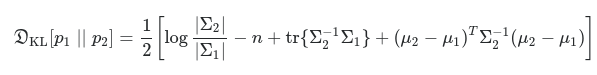

Assuming a unit gaussian as prior, we obtain a very simple equation that will help you to implement it in pytorch:

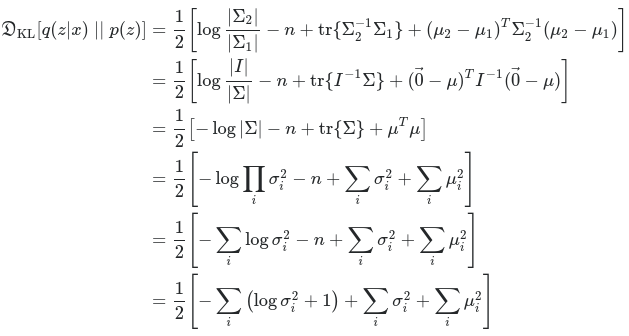

Note that, in these equations sigma denotes the standard deviation while the encoder network ouputs the log of the variance.  

Dans le code ci-dessous, on crée une instance de la classe "VAE". 

Les paramètres spécifiés sont :

**x_dim=784 :** C'est la dimension d'entrée. Pour les images MNIST qui sont de taille 28x28, les images sont aplaties en un vecteur de taille 784 (28*28).

**h_dim1=512** et **h_dim2=256 :** Ces paramètres définissent les dimensions des **couches cachées** dans l'encoder et le decoder du VAE.\

**z_dim=2 :** La dimension de l'espace latent. C'est la taille du **vecteur latent z** qui est généré par l'encoder.

In [45]:
# build model
# On fait appel à la classe "VAE" construite plus haut
vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=2)

if torch.cuda.is_available():
    vae.cuda()
optimizer = optim.Adam(vae.parameters())

# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    # BCE is used as the reconstruction loss
    RecLoss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    
    # KL divergence loss as derived for VAE
    KLDLoss = -0.5 * torch.sum(log_var + 1 - log_var.exp() - mu.pow(2))
    
    return RecLoss + KLDLoss

La fonction **"loss_function"** définit la fonction de perte utilisée pour entraîner le VAE. Elle prend en compte deux termes :

**Reconstruction Loss (RecLoss):** Mesure la différence entre l'entrée originale x et sa reconstruction recon_x. La perte de reconstruction est calculée en utilisant l'erreur quadratique binaire (binary_cross_entropy) entre l'image originale et l'image reconstruite, ce qui est courant pour les modèles génératifs où les sorties sont des probabilités de pixels. reduction='sum' indique que la perte sera sommée sur toutes les instances dans le lot.

**KL Divergence Loss (KLDLoss):** Cette perte mesure à quel point la distribution apprise dans l'espace latent (représentée par mu et log_var) dévie d'une distribution gaussienne standard (normale). C'est un terme de régularisation qui encourage l'espace latent à avoir de bonnes propriétés, permettant la génération et l'interpolation. La formule utilisée ici est une simplification qui découle directement de la divergence KL entre deux gaussiennes.

**RecLoss est calculé en utilisant la perte de cross-entropy binaire.**

## Training step
In this cell, we define the function that performs training on one epoch. We recommend to debug it using the "main loop" cell later in the page.

In [57]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)  # Envoyer les données au CPU
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)  # Forward pass
        loss = loss_function(recon_batch, data, mu, log_var)  # Compute loss
        
        loss.backward()  # Compute gradients
        train_loss += loss.item()  # Aggregate the loss
        optimizer.step()  # Update weights
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
            
    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))

vae = vae.to(device)

## Visualization

Nous construisons deux fonctions "plotLoss" et "plotGeneratedImages". La première permet de tracer la fonction perte et la seconde les images générées.

In [48]:
# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(generatedImages,dim=(10, 10), figsize=(10, 10)):
    generatedImages=generatedImages.cpu().numpy()
    print(generatedImages.shape)
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(np.squeeze(generatedImages[i]), interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)
    IPython.display.display(IPython.display.Image(data=('gan_generated_image_epoch_%d.png' % epoch)))

## Test
Complete the test function that generate new sample from latent space samples. 

In [50]:
def test():
    vae.eval()  # Mettre le modèle en mode évaluation
    test_loss = 0
    with torch.no_grad():  # Pas de calcul de gradients nécessaire, cela permet d'optimiser les ressources 
        for data, _ in test_loader:
            data = data.to(device)          # Envoyer les données au CPU
            recon, mu, log_var = vae(data)  # Passer les données à travers le modèle
            
            test_loss += loss_function(recon, data, mu, log_var).item()  # On cumule les pertes

    test_loss /= len(test_loader.dataset)  # Calculer la perte moyenne
    print('====> Test set loss: {:.4f}'.format(test_loss))

    # Générer de nouvelles données à partir de l'espace latent
    with torch.no_grad():
        z = torch.randn(64, 2).to(device)  # Échantillonner aléatoirement des points dans l'espace latent
        generated = vae.decoder(z)  # Générer des données à partir de z
        plotGeneratedImages(generated.view(generated.size(0), 1, 28, 28))  # Visualiser les images

        # Si nécessaire, enregistrer les images générées
        save_image(generated.view(64, 1, 28, 28), 'sample.png')

## Main loop

Pour chaque lot, on entraine le modèle.

Train Epoch: 1 [0/60000 (0%)]	Loss: 547.308047
Train Epoch: 1 [10000/60000 (17%)]	Loss: 189.116016
Train Epoch: 1 [20000/60000 (33%)]	Loss: 172.511465
Train Epoch: 1 [30000/60000 (50%)]	Loss: 175.537715
Train Epoch: 1 [40000/60000 (67%)]	Loss: 158.434316
Train Epoch: 1 [50000/60000 (83%)]	Loss: 165.284590
====> Epoch: 1 Average loss: 179.1361
Train Epoch: 2 [0/60000 (0%)]	Loss: 167.680703
Train Epoch: 2 [10000/60000 (17%)]	Loss: 169.577285
Train Epoch: 2 [20000/60000 (33%)]	Loss: 156.541631
Train Epoch: 2 [30000/60000 (50%)]	Loss: 151.697734
Train Epoch: 2 [40000/60000 (67%)]	Loss: 163.428799
Train Epoch: 2 [50000/60000 (83%)]	Loss: 151.814756
====> Epoch: 2 Average loss: 158.7254
Train Epoch: 3 [0/60000 (0%)]	Loss: 149.047432
Train Epoch: 3 [10000/60000 (17%)]	Loss: 160.976611
Train Epoch: 3 [20000/60000 (33%)]	Loss: 157.542871
Train Epoch: 3 [30000/60000 (50%)]	Loss: 148.456035
Train Epoch: 3 [40000/60000 (67%)]	Loss: 159.134678
Train Epoch: 3 [50000/60000 (83%)]	Loss: 153.845996
===

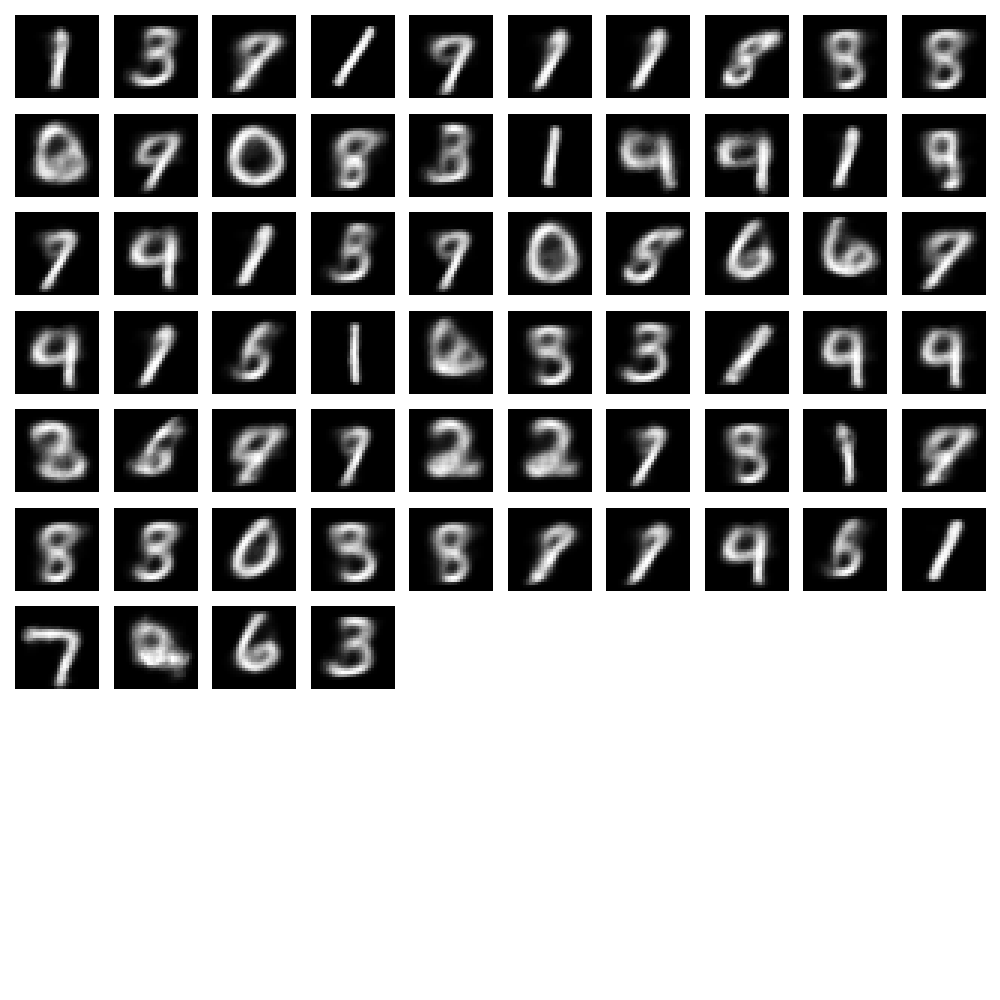

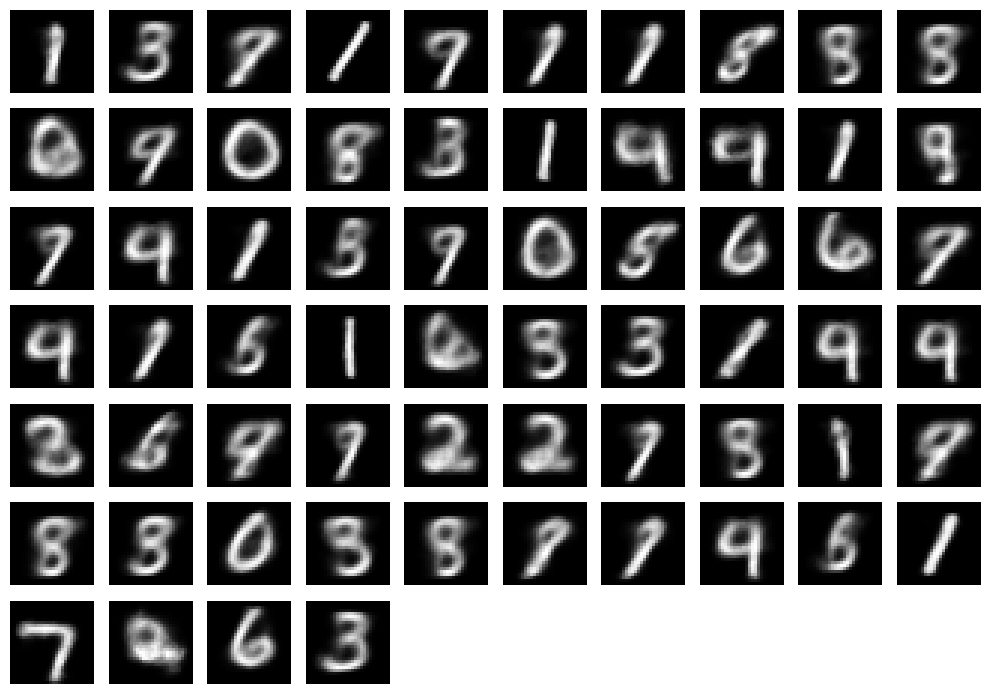

In [51]:
for epoch in range(1, 5):
    train(epoch)
test()

## Bonus 1: Interpolation
Sample two latent vectors z1 and z2 and generate the corresponding images. Then, generate 10 intermediate images by performing linear interpolation in the latent space between the z1 and z2.

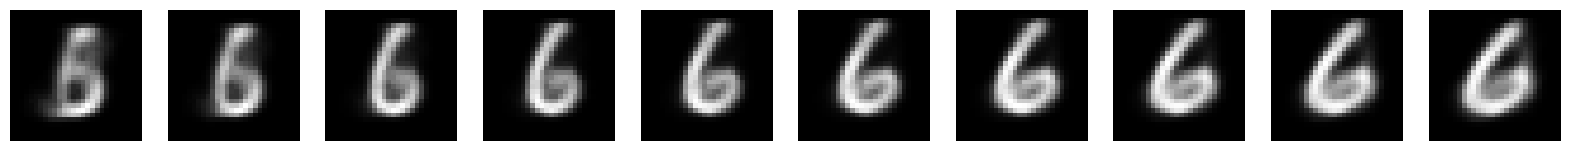

In [81]:
device = torch.device('cpu')
vae = vae.to(device)

def interpolate(z1, z2, steps=10):
    """
    Fonction pour interpoler linéairement entre deux points dans un espace latent.
    """
    z = [z1 * (1 - i/(steps-1)) + z2 * (i/(steps-1)) for i in range(steps)]
    return torch.stack(z)

def plot_images(images):
    """
    Fonction pour afficher une grille d'images.
    """
    fig, axes = plt.subplots(1, len(images), figsize=(20, 2))
    for ax, img in zip(axes, images):
        ax.imshow(img.reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

# Échantillonner deux vecteurs latents aléatoires
z1 = torch.randn(1, 2).to(device)
z2 = torch.randn(1, 2).to(device)

# Interpoler entre z1 et z2
z_interp = interpolate(z1, z2, steps=10)

# Générer des images à partir de l'espace latent interpolé
with torch.no_grad():
    generated = vae.decoder(z_interp).cpu()

# Afficher les images générées
plot_images(generated)

## Bonus 2: Visualization
Generate a 10x10 mosaic by sampling *z* over a regulargrid in [-1,1]x[-1,1]. What do you observe? 


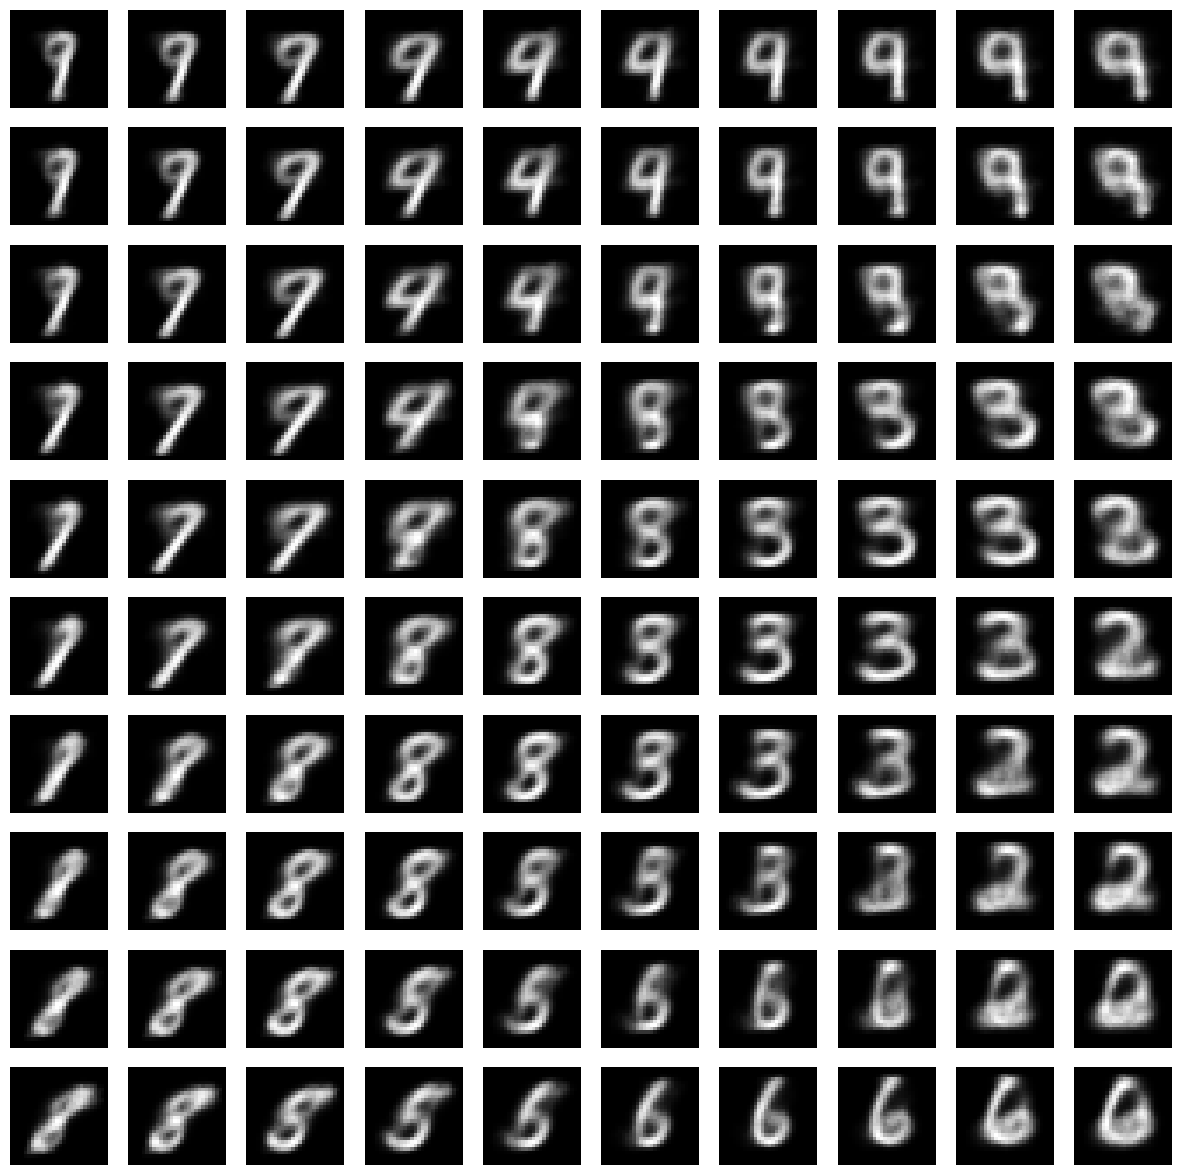

In [53]:
device = torch.device('cpu')
vae = vae.to(device)

def generate_mosaic(z_dim=2, grid_size=10):
    """
    Génère une mosaïque d'images à partir de vecteurs latents échantillonnés sur une grille régulière.
    """
    # Créer une grille régulière de valeurs dans [-1, 1] pour chaque dimension de l'espace latent
    grid = np.linspace(-1, 1, grid_size)
    xv, yv = np.meshgrid(grid, grid)
    
    # Préparer la grille pour le décodeur
    z_grid = np.stack([xv.ravel(), yv.ravel()], axis=1)
    z_grid = torch.from_numpy(z_grid).float().to(device)
    
    # Générer des images à partir de la grille de l'espace latent
    with torch.no_grad():
        generated = vae.decoder(z_grid).cpu()
    
    # Afficher les images sous forme de mosaïque
    fig, ax = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    for i, axi in enumerate(ax.flat):
        axi.imshow(generated[i].view(28, 28), cmap='gray')
        axi.axis('off')
    plt.show()

generate_mosaic(z_dim=2, grid_size=10)

On observe comment de légères variations dans l'espace latent se traduisent par des changements dans les caractéristiques des chiffres générés. Cela peut illustrer la continuité et la "lissitude" de l'espace latent appris par le VAE, où des points proches dans l'espace latent produisent des chiffres visuellement similaires.

################################################ **Merci de m'avoir lu** ################################################